# Dimensionality Reduction with t-SNE & Scikit-Learn

Here's what you'll find in this notebook.

- Train an auto-encoder network to (a) encode images as codings and (b) generate new images from those embeddings.
- Reduce the dataset's dimensionality to two dimensions (x and y coordinates).
- Plot data samples by similarity using those coordinates.

🎥 [Watch this video](https://www.youtube.com/watch?v=DtFQAJmlID0) for a hands-on tutorial.

🐍 Notebook developed by [Nono Martínez Alonso](https://twitter.com/nonoesp) during [Live 38](https://nono.ma/live/38).

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
print("TensorFlow",tf.__version__)
!python --version
# List devices available to TensorFlow
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

TensorFlow 2.5.0
Python 3.7.11
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4088416286107725055
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7359773067597735450
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## Settings

In [ ]:
IMG_WIDTH = 28
IMG_HEIGHT = 28
BUFFER_SIZE = 104
BATCH_SIZE = 104

## Load Custom Dataset

Images are RGB jpegs of 28x28 pixels.

In [ ]:
!rm -rf sketches || true && unzip -q sketches.zip -d sketches

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

from PIL import ImageOps
def digits_to_img(digits):
  arr = np.array(tf.expand_dims(tf.expand_dims(digits, axis=1), axis=0))
  img = tf.keras.preprocessing.image.array_to_img(arr)
  inverted_img = ImageOps.invert(img)  
  return inverted_img

def plot_digits(digits):
  plot_image(digits_to_img(digits))

In [ ]:
def decode_input_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Convert to floats in the [0, 1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Convert to grayscale
  img = tf.image.rgb_to_grayscale(img)
  # Resize the image to the desired size (28x28)
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT], antialias=True)

def load_image_train(file_path):
  input_image = tf.io.read_file(file_path)
  input_image = decode_input_img(input_image)
  input_image = tf.reshape(input_image, (28,28))
  # TODO: possible processing

  return input_image

train_files = tf.data.Dataset.list_files(str('sketches/*.jpg'), shuffle=False)
train = train_files.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset

<RepeatDataset shapes: (None, 28, 28), types: tf.float32>

In [ ]:
# Load images manually
from glob import glob

data = []

for file_path in glob('sketches/*'):
  img = load_image_train(file_path)
  data.append(img)

data = np.array(data)

X_train_full = data
X_train, X_valid = X_train_full[:-20], X_train_full[-20:]
X_train_sketches, X_valid_sketches = (X_train, X_valid)

In [ ]:
# Uncomment to use Fashion MNIST dataset instead

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Define Encoder & Decoder

In [ ]:
stacked_encoder = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=[28,28]),
  tf.keras.layers.Dense(100, activation="selu"),
  tf.keras.layers.Dense(30, activation="selu", name="30UnitsDense"),
])
stacked_encoder

In [ ]:
stacked_decoder = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, activation="selu", input_shape=[30]),
  tf.keras.layers.Dense(28 * 28, activation="sigmoid"),
  tf.keras.layers.Reshape([28, 28])
])
stacked_decoder

## Define Stacked Auto-Encoder

In [ ]:
stacked_autoencoder = tf.keras.models.Sequential([
  stacked_encoder, # stacked_autoencoder.layers[0]
  stacked_decoder, # stacked_autoencoder.layers[1]
])
stacked_autoencoder

## Train model


In [ ]:
def rounded_accuracy(y_true, y_pred):
  return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
stacked_autoencoder.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.5),
    metrics=[rounded_accuracy],
)

In [ ]:
stacked_autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 30)                81530     
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = stacked_autoencoder.fit(X_train, X_train, epochs=20,
                                  validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2852 - rounded_accuracy: 0.9330 - val_loss: 0.2862 - val_rounded_accuracy: 0.9339
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2846 - rounded_accuracy: 0.9336 - val_loss: 0.2862 - val_rounded_accuracy: 0.9336
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2840 - rounded_accuracy: 0.9341 - val_loss: 0.2850 - val_rounded_accuracy: 0.9354
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2836 - rounded_accuracy: 0.9344 - val_loss: 0.2847 - val_rounded_accuracy: 0.9348
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2831 - rounded_accuracy: 0.9348 - val_loss: 0.2843 - val_rounded_accuracy: 0.9342
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2827 - rounded_accuracy: 0.9350 - val_loss: 0.2852 - val_rounded_accuracy: 0.9342
Epoch 7/20
1719/1719 [==================

## Encode entire dataset

(28, 28)


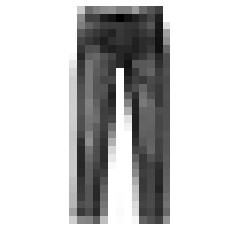

In [ ]:
# Current dataset
input = X_train[16]
print(input.shape)
plot_image(input)

In [ ]:
# # Force custom-loaded dataset
# input = X_train_sketches[56]
# print(input.shape)
# input = 1 - input
# plot_image(input)

In [ ]:
# After training 10+50 epochs
codings = stacked_encoder.predict(tf.expand_dims(input, [0]))
codings

array([[-1.7573    ,  3.7448754 ,  0.29755723, -1.7571093 , -1.5058917 ,
         4.8423123 , -0.29157907, -1.7580972 ,  5.286306  , -1.4555544 ,
        -1.7573587 ,  3.3782754 , 13.703759  ,  6.7550855 ,  4.129732  ,
        -1.7022294 ,  9.756428  , -1.7576796 ,  6.468301  , -1.6694831 ,
        -1.7508535 ,  6.1976724 ,  7.243982  , -1.747775  ,  8.053645  ,
         9.668753  , -1.7548614 , -1.7578529 ,  5.5022244 ,  4.7810836 ]],
      dtype=float32)

In [ ]:
# After training 10 epochs
# codings = stacked_encoder.predict(tf.expand_dims(input, [0]))
# codings

In [ ]:
# codings = np.array([[12.249407  ,  0.61440265,  0.3469532 , -1.7477232 , -1.7530328 ,
#          1.5583827 , -1.0914552 , -1.7519665 ,  0.84685075,  1.596751  ,
#          3.3866253 , -0.34639496, 12.03499   ,  1.7342    ,  4.153645  ,
#         -1.6927444 , 12.473064  ,  2.3530746 ,  3.857507  ,  5.559803  ,
#          6.139968  ,  3.8874714 , -1.7489266 ,  3.4787664 , -1.6934825 ,
#         13.803295  ,  2.881654  ,  3.176866  ,  1.1571326 , 13.173834  ]])
# codings

In [ ]:
# codings = np.array([[2.249407  ,  0.61440265,  0.3469532 , -1.7477232 , -1.7530328 ,
#          4.5583827 , -1.0914552 , -1.7519665 ,  0.84685075,  1.596751  ,
#          8.3866253 , -0.34639496, 12.03499   ,  1.7342    ,  4.153645  ,
#         -4.6927444 , 12.473064  ,  2.3530746 ,  3.857507  ,  5.559803  ,
#          0.139968  ,  3.8874714 , -1.7489266 ,  3.4787664 , -1.6934825 ,
#         3.803295  ,  2.881654  ,  3.176866  ,  1.1571326 , 13.173834  ]])
# codings

In [ ]:
plot_digits(codings[0])

In [ ]:
plot_digits(codings[0])

In [ ]:
generated_img = stacked_decoder.predict(codings)
generated_img[0].shape

(28, 28)

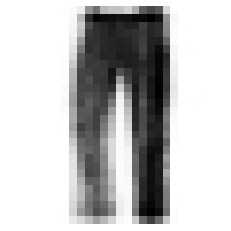

In [ ]:
plot_image(generated_img[0])

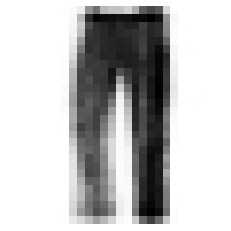

In [ ]:
plot_image(generated_img[0])

In [ ]:
# plot_image(generated_img[0])

In [ ]:
# plot_image(generated_img[0])

## Dimensionality reduction with t-SNE

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom=1, cmap="gray"):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom, cmap=cmap)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], s=10, cmap="tab10")
# plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")

## Render t-SNE sketches

In [ ]:
# from sklearn.manifold import TSNE

# X_train_compressed = stacked_encoder.predict(X_train)
# tsne = TSNE()
# X_train_2D = tsne.fit_transform(X_train_compressed)

In [ ]:
# colors = []
# i = 0
# j = 0
# for n in range(84):
#   if i > 25:
#     i = 0
#     j += 1
#   colors.append(j)
#   i += 1

In [ ]:
# plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=colors, s=10, cmap="tab10")

In [ ]:
# visualize_scatter_with_images(
#     X_train_2D,
#     images = [np.reshape(i, (28,28)) for i in X_train],
#     image_zoom=3.0
#   )

## Render t-SNE images of Fashion MNIST

In [ ]:
from sklearn.manifold import TSNE

inputs = X_valid[:2500]

X_valid_compressed = stacked_encoder.predict(inputs)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

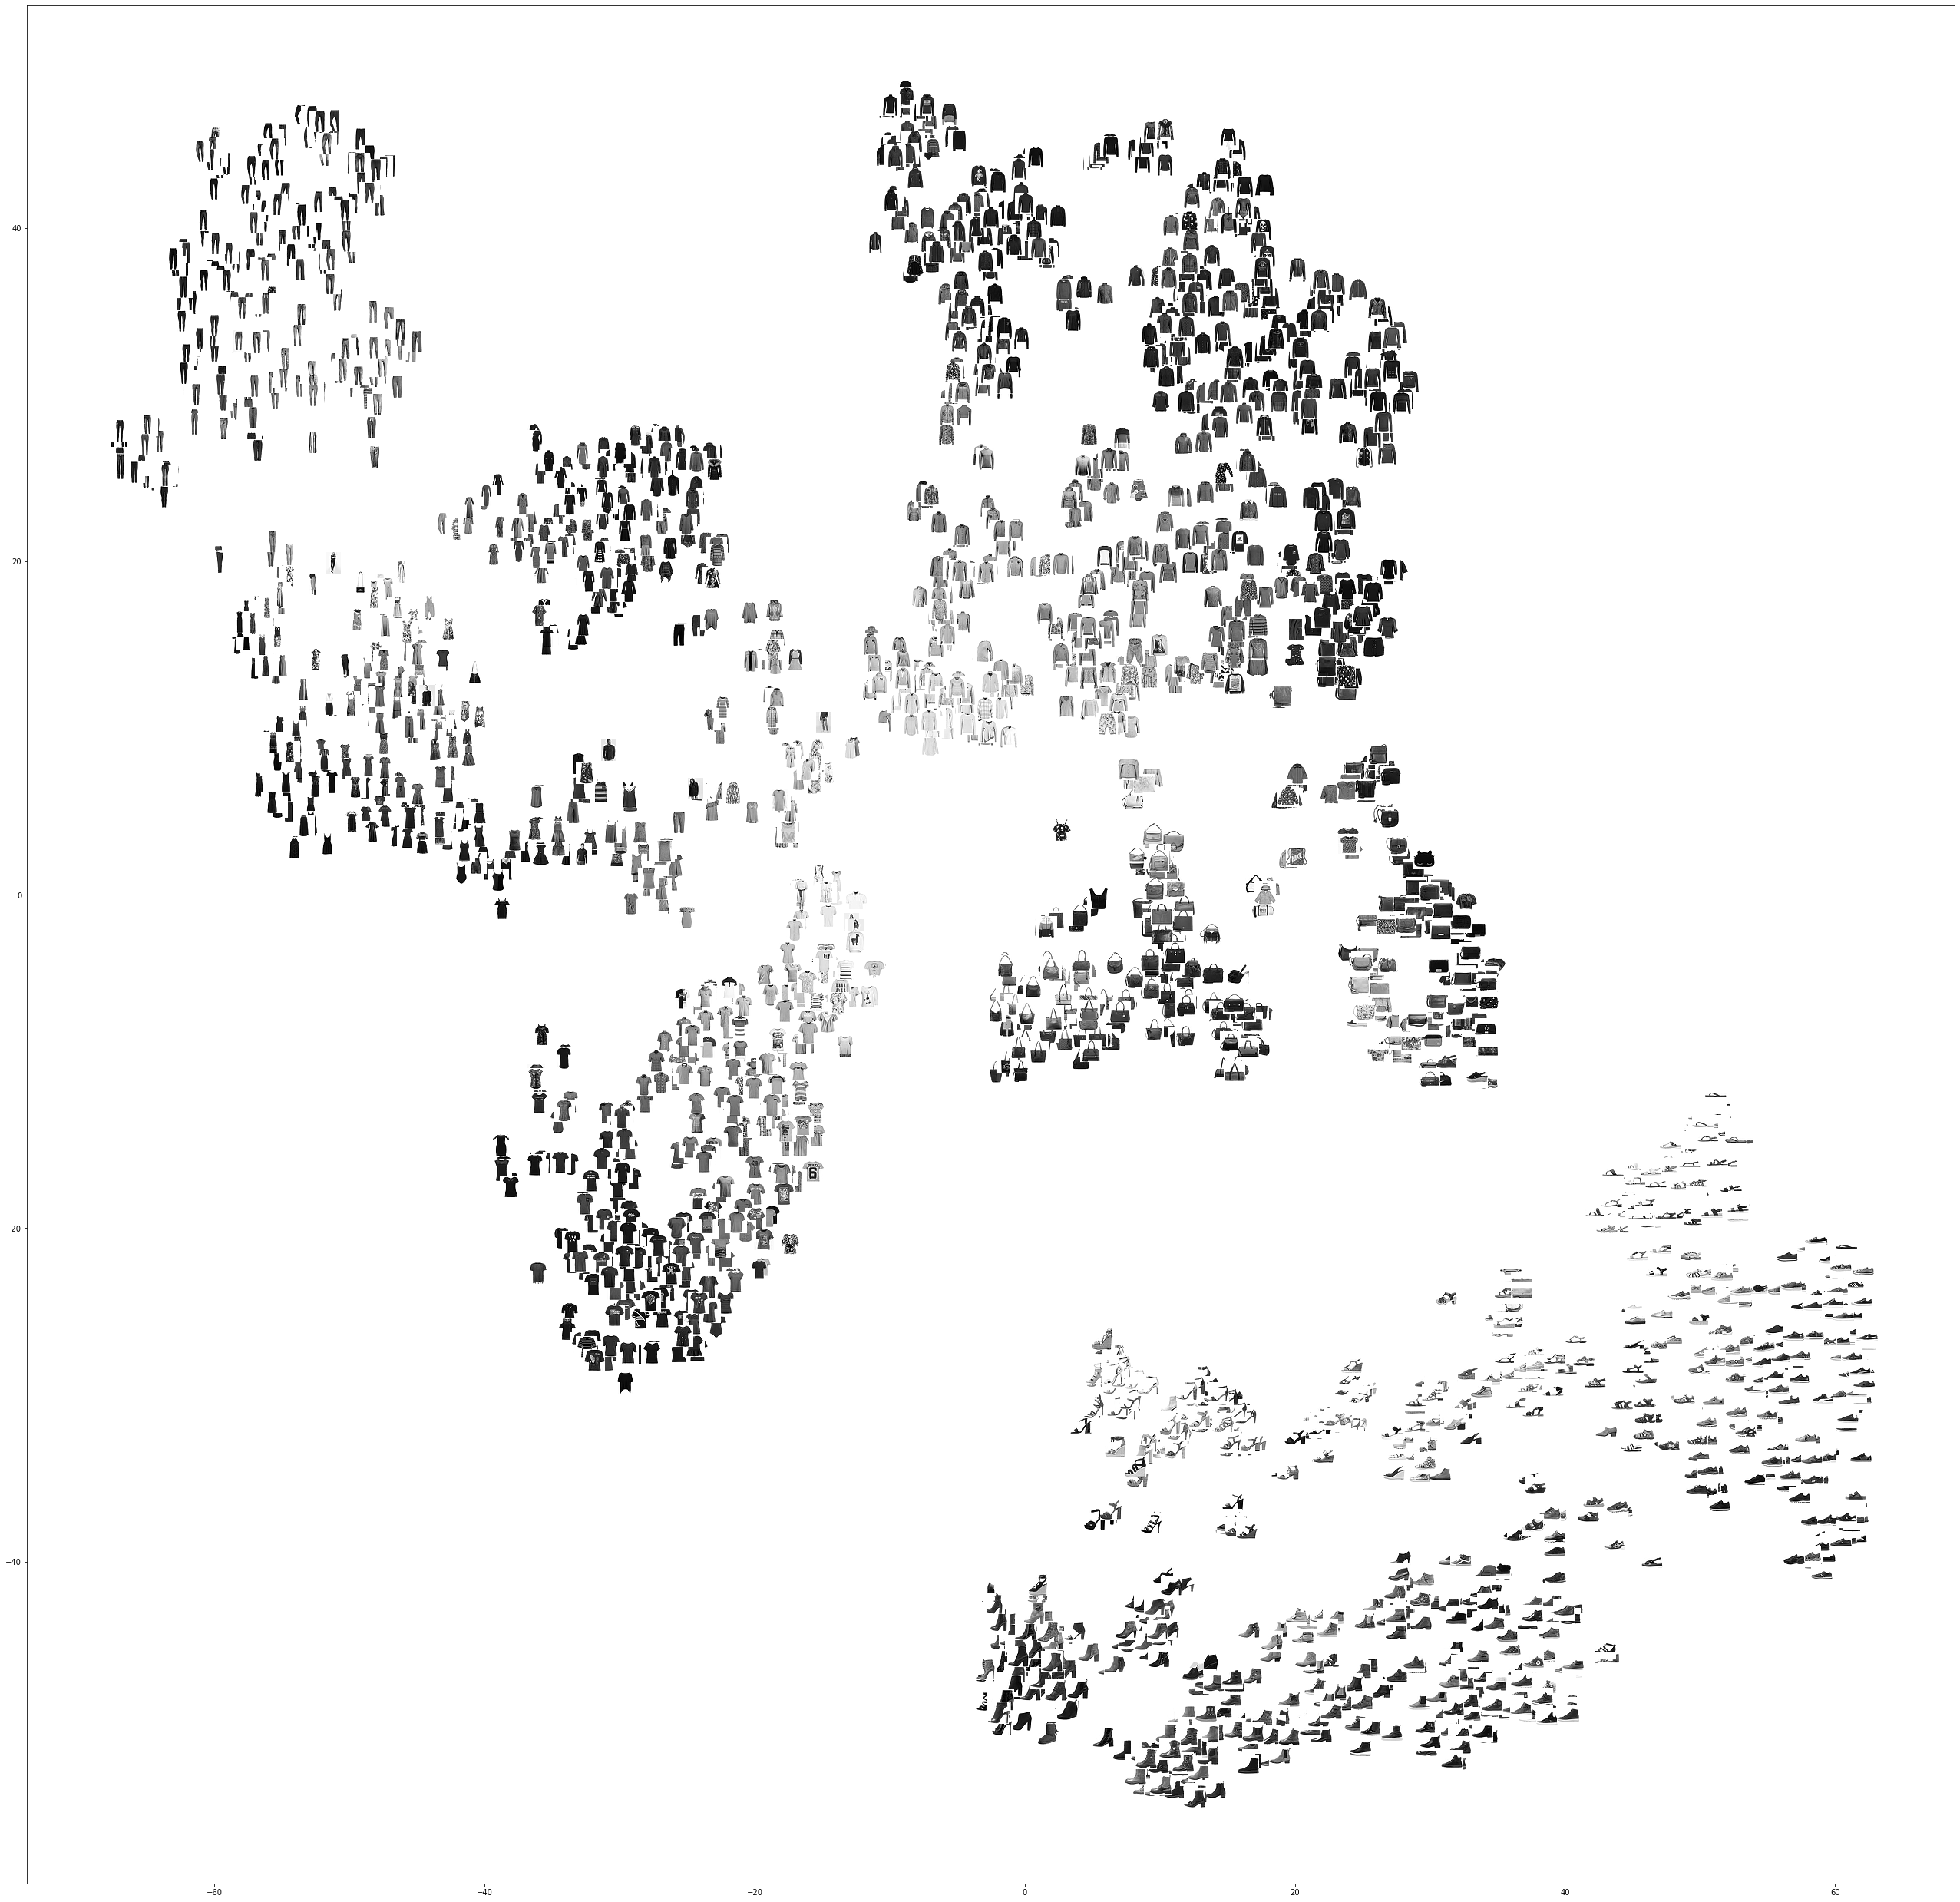

In [ ]:
visualize_scatter_with_images(
  X_valid_2D,
  images = [np.reshape(i, (28,28)) for i in inputs],
  image_zoom=1.0,
  cmap="gray_r"
)